In [46]:
from transformers import pipeline
from nltk import sent_tokenize
import nltk
import torch
from glob import glob
import pandas as pd
import numpy as np

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/abdullah/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Load Model

In [6]:
model_name = "facebook/bart-large-mnli"
device = 0 if torch.cuda.is_available() else 'cpu'

In [8]:
def load_model(device):
    theme_classifier = pipeline(
        "zero-shot-classification",
        model=model_name,
        device=device
    )

    return theme_classifier

In [9]:
theme_classifier = load_model(device)

/home/abdullah/python_virtual_env/gradio_env/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [10]:
theme_list = ["friendship","hope","sacrifice","battle","self development","betrayal","love","dialogue"]

In [11]:
theme_classifier(
    "I gave him a right hook then a left jab",
    theme_list,
    multi_label=True
)

{'sequence': 'I gave him a right hook then a left jab',
 'labels': ['battle',
  'self development',
  'hope',
  'sacrifice',
  'dialogue',
  'betrayal',
  'love',
  'friendship'],
 'scores': [0.9121254086494446,
  0.47500181198120117,
  0.0878182053565979,
  0.045000456273555756,
  0.020132921636104584,
  0.012040475383400917,
  0.0042923809960484505,
  0.002817221451550722]}

# Load Dataset

In [13]:
files = glob('../data/Subtitles/*.ass')

In [14]:
files[:5]

['../data/Subtitles/Naruto Season 1 - 01.ass',
 '../data/Subtitles/Naruto Season 1 - 02.ass',
 '../data/Subtitles/Naruto Season 1 - 03.ass',
 '../data/Subtitles/Naruto Season 1 - 04.ass',
 '../data/Subtitles/Naruto Season 1 - 05.ass']

In [16]:
with open(files[0],'r') as file:
    lines = file.readlines()
    lines = lines[27:]
    lines =  [ ",".join(line.split(',')[9:])  for line in lines ]

In [17]:
lines[:2]

['A long time ago, a powerful demon fox\\Nappeared with nine tails.\n',
 'With its powerful tails,\n']

In [18]:
lines = [ line.replace('\\N',' ') for line in lines]

In [19]:
lines[:2]

['A long time ago, a powerful demon fox appeared with nine tails.\n',
 'With its powerful tails,\n']

In [20]:
" ".join(lines[:10])

"A long time ago, a powerful demon fox appeared with nine tails.\n With its powerful tails,\n it could smash mountains and create tidal waves.\n A band of Ninjas rose to defend their village from attack.\n We have to wait until the Fourth Hokage gets here!\n We can't let it get any closer to our village!\n One great Ninja was able to imprison the monster,\n but died in the process.\n This Ninja was known as… the Fourth Hokage.\n Naruto!\n"

In [25]:
int(files[0].split('-')[-1].split('.')[0].strip())

1

In [29]:
def load_subtitles_dataset(dataset_path):
    subtitles_paths = glob(dataset_path+'/*.ass')

    scripts=[]
    episode_num=[]

    for path in subtitles_paths:

        #Read Lines
        with open(path,'r') as file:
            lines = file.readlines()
            lines = lines[27:]
            lines =  [ ",".join(line.split(',')[9:])  for line in lines ]
        
        lines = [ line.replace('\\N',' ') for line in lines]
        script = " ".join(lines)

        episode = int(path.split('-')[-1].split('.')[0].strip())

        scripts.append(script)
        episode_num.append(episode)

    df = pd.DataFrame.from_dict({"episode":episode_num, "script":scripts })
    return df

In [31]:
dataset_path = "../data/Subtitles"
df = load_subtitles_dataset(dataset_path)

In [32]:
df.head()

,episode,script
0,1,"A long time ago, a powerful demon fox appeared..."
1,2,"C'mon!\n Running like a fugitive,\n Being chas..."
2,3,"C'mon!\n Running like a fugitive,\n Being chas..."
3,4,"C'mon!\n Running like a fugitive,\n Being chas..."
4,5,"C'mon!\n Running like a fugitive,\n Being chas..."


Run Model

In [33]:
script = df.iloc[0]['script']

In [34]:
script

'A long time ago, a powerful demon fox appeared with nine tails.\n With its powerful tails,\n it could smash mountains and create tidal waves.\n A band of Ninjas rose to defend their village from attack.\n We have to wait until the Fourth Hokage gets here!\n We can\'t let it get any closer to our village!\n One great Ninja was able to imprison the monster,\n but died in the process.\n This Ninja was known as… the Fourth Hokage.\n Naruto!\n Why did you do such a thing?!\n You\'re really gonna get it this time!\n I don\'t care!\n You know your problem?\n You can\'t do the things I do!\n Only I can do this!\n I\'m better than all of you! Believe it!\n There\'s a problem, sir!\n Lord Hokage!\n What is it?\n Did that Naruto do something again?\n Yes. He climbed onto the Mountainside Images…\n And he vandalized and graffitied all over them!\n Wait!\n Ha ha…\n Why should I?\n Hey, Naruto!\n How did you suddenly get here, lruka Sensei?\n The question is what are you doing here when you should 

In [36]:
script_sentences = sent_tokenize(script)
script_sentences[:3]

['A long time ago, a powerful demon fox appeared with nine tails.',
 'With its powerful tails,\n it could smash mountains and create tidal waves.',
 'A band of Ninjas rose to defend their village from attack.']

In [39]:
# Batch Sentence
sentence_batch_size=20
script_batches = []
for index in range(0,len(script_sentences),sentence_batch_size):
    sent = " ".join(script_sentences[index:index+sentence_batch_size])
    script_batches.append(sent)

In [40]:
script_batches[:2]

["A long time ago, a powerful demon fox appeared with nine tails. With its powerful tails,\n it could smash mountains and create tidal waves. A band of Ninjas rose to defend their village from attack. We have to wait until the Fourth Hokage gets here! We can't let it get any closer to our village! One great Ninja was able to imprison the monster,\n but died in the process. This Ninja was known as… the Fourth Hokage. Naruto! Why did you do such a thing?! You're really gonna get it this time! I don't care! You know your problem? You can't do the things I do! Only I can do this! I'm better than all of you! Believe it! There's a problem, sir! Lord Hokage! What is it? Did that Naruto do something again?",
 'Yes. He climbed onto the Mountainside Images…\n And he vandalized and graffitied all over them! Wait! Ha ha…\n Why should I? Hey, Naruto! How did you suddenly get here, lruka Sensei? The question is what are you doing here when you should be in class now? Now listen, Naruto. You failed t

In [41]:
theme_output = theme_classifier(
    script_batches[:2],
    theme_list,
    multi_label=True
)

/home/abdullah/python_virtual_env/gradio_env/lib/python3.8/site-packages/torch/utils/data/dataloader.py:643: UserWarning: Length of IterableDataset <transformers.pipelines.pt_utils.PipelineChunkIterator object at 0x7f79f4113e50> was reported to be 2 (when accessing len(dataloader)), but 3 samples have been fetched. 
  warnings.warn(warn_msg)
/home/abdullah/python_virtual_env/gradio_env/lib/python3.8/site-packages/torch/utils/data/dataloader.py:643: UserWarning: Length of IterableDataset <transformers.pipelines.pt_utils.PipelineChunkIterator object at 0x7f79f4113e50> was reported to be 2 (when accessing len(dataloader)), but 4 samples have been fetched. 
  warnings.warn(warn_msg)
/home/abdullah/python_virtual_env/gradio_env/lib/python3.8/site-packages/torch/utils/data/dataloader.py:643: UserWarning: Length of IterableDataset <transformers.pipelines.pt_utils.PipelineChunkIterator object at 0x7f79f4113e50> was reported to be 2 (when accessing len(dataloader)), but 5 samples have been fetc

In [42]:
theme_output

[{'sequence': "A long time ago, a powerful demon fox appeared with nine tails. With its powerful tails,\n it could smash mountains and create tidal waves. A band of Ninjas rose to defend their village from attack. We have to wait until the Fourth Hokage gets here! We can't let it get any closer to our village! One great Ninja was able to imprison the monster,\n but died in the process. This Ninja was known as… the Fourth Hokage. Naruto! Why did you do such a thing?! You're really gonna get it this time! I don't care! You know your problem? You can't do the things I do! Only I can do this! I'm better than all of you! Believe it! There's a problem, sir! Lord Hokage! What is it? Did that Naruto do something again?",
  'labels': ['dialogue',
   'betrayal',
   'battle',
   'sacrifice',
   'self development',
   'hope',
   'friendship',
   'love'],
  'scores': [0.9800740480422974,
   0.939690351486206,
   0.8546885848045349,
   0.7349812388420105,
   0.7284971475601196,
   0.1990973204374313

In [43]:
# Wrangle Ouput
# battle: [0.51489498, 0.2156498]
themes = {}
for output in theme_output:
    for label,score in zip(output['labels'],output['scores']):
        if label not in themes:
            themes[label] = []
        themes[label].append(score)

In [49]:
themes = {key: np.mean(np.array(value)) for key,value in themes.items()}

In [50]:
themes

{'dialogue': 0.9585433900356293,
 'betrayal': 0.7927076518535614,
 'battle': 0.7564102113246918,
 'sacrifice': 0.6804327070713043,
 'self development': 0.7981590628623962,
 'hope': 0.20166856795549393,
 'friendship': 0.07262829504907131,
 'love': 0.03414116054773331}

In [51]:
def get_themes_inference(script):
    script_sentences = sent_tokenize(script)

    # Batch Sentence
    sentence_batch_size=20
    script_batches = []
    for index in range(0,len(script_sentences),sentence_batch_size):
        sent = " ".join(script_sentences[index:index+sentence_batch_size])
        script_batches.append(sent)
    
    # Run Model
    theme_output = theme_classifier(
        script_batches[:2],
        theme_list,
        multi_label=True
    )

    # Wrangle Output 
    themes = {}
    for output in theme_output:
        for label,score in zip(output['labels'],output['scores']):
            if label not in themes:
                themes[label] = []
            themes[label].append(score)

    themes = {key: np.mean(np.array(value)) for key,value in themes.items()}

    return themes

In [52]:
df = df.head(2)

In [53]:
df

,episode,script
0,1,"A long time ago, a powerful demon fox appeared..."
1,2,"C'mon!\n Running like a fugitive,\n Being chas..."


In [54]:
output_themes = df['script'].apply(get_themes_inference)

/home/abdullah/python_virtual_env/gradio_env/lib/python3.8/site-packages/torch/utils/data/dataloader.py:643: UserWarning: Length of IterableDataset <transformers.pipelines.pt_utils.PipelineChunkIterator object at 0x7f7a001c7160> was reported to be 2 (when accessing len(dataloader)), but 3 samples have been fetched. 
  warnings.warn(warn_msg)
/home/abdullah/python_virtual_env/gradio_env/lib/python3.8/site-packages/torch/utils/data/dataloader.py:643: UserWarning: Length of IterableDataset <transformers.pipelines.pt_utils.PipelineChunkIterator object at 0x7f7a001c7160> was reported to be 2 (when accessing len(dataloader)), but 4 samples have been fetched. 
  warnings.warn(warn_msg)
/home/abdullah/python_virtual_env/gradio_env/lib/python3.8/site-packages/torch/utils/data/dataloader.py:643: UserWarning: Length of IterableDataset <transformers.pipelines.pt_utils.PipelineChunkIterator object at 0x7f7a001c7160> was reported to be 2 (when accessing len(dataloader)), but 5 samples have been fetc

In [55]:
output_themes

0    {'dialogue': 0.9585433900356293, 'betrayal': 0...
1    {'dialogue': 0.9606060087680817, 'sacrifice': ...
Name: script, dtype: object

In [58]:
theme_df = pd.DataFrame(output_themes.tolist())

In [59]:
theme_df

,dialogue,betrayal,battle,sacrifice,self development,hope,friendship,love
0,0.958543,0.792708,0.756410,0.680433,0.798159,0.201669,0.072628,0.034141
1,0.960606,0.429944,0.684846,0.570704,0.482810,0.154534,0.046261,0.173261


In [60]:
df

,episode,script
0,1,"A long time ago, a powerful demon fox appeared..."
1,2,"C'mon!\n Running like a fugitive,\n Being chas..."


In [61]:
df[theme_df.columns] = theme_df
df

,episode,script,dialogue,betrayal,battle,sacrifice,self development,hope,friendship,love
0,1,"A long time ago, a powerful demon fox appeared...",0.958543,0.792708,0.756410,0.680433,0.798159,0.201669,0.072628,0.034141
1,2,"C'mon!\n Running like a fugitive,\n Being chas...",0.960606,0.429944,0.684846,0.570704,0.482810,0.154534,0.046261,0.173261


# Visualize ouput

In [63]:
df = df.drop('dialogue',axis=1)

In [67]:
theme_output = df.drop(['episode','script'],axis=1).sum().reset_index()
theme_output.columns = ['theme','score']
theme_output

,theme,score
0,betrayal,1.222652
1,battle,1.441256
2,sacrifice,1.251136
3,self development,1.280969
4,hope,0.356202
5,friendship,0.118889
6,love,0.207402


In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

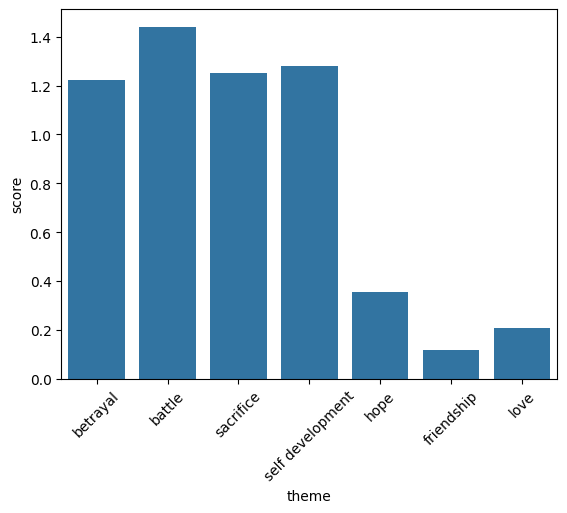

In [70]:
sns.barplot(data = theme_output ,x="theme",y="score" )
plt.xticks(rotation=45)
plt.show()